In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist

In [2]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
print(dataframe.shape)
dataframe.head()

(4998, 141)


,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [3]:
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

In [4]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [5]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

train_data, normal_test_data, anomalous_train_data

(<tf.Tensor: shape=(3998, 140), dtype=float32, numpy=
 array([[0.57030463, 0.46561658, 0.29058117, ..., 0.48504233, 0.4233502 ,
         0.47598344],
        [0.48320588, 0.28246963, 0.16471253, ..., 0.567567  , 0.4677294 ,
         0.2692329 ],
        [0.48144642, 0.35151404, 0.25972766, ..., 0.5479421 , 0.5077544 ,
         0.54298663],
        ...,
        [0.41039047, 0.24164985, 0.13120876, ..., 0.5277313 , 0.5654091 ,
         0.5023885 ],
        [0.5397748 , 0.4140786 , 0.28101394, ..., 0.51266515, 0.43706053,
         0.4426865 ],
        [0.29639772, 0.15988176, 0.18883787, ..., 0.53766966, 0.545786  ,
         0.40826708]], dtype=float32)>,
 <tf.Tensor: shape=(560, 140), dtype=float32, numpy=
 array([[0.48035768, 0.28877792, 0.19828546, ..., 0.45463306, 0.5246125 ,
         0.3713729 ],
        [0.45354807, 0.2557325 , 0.15979648, ..., 0.4801337 , 0.5284734 ,
         0.49527124],
        [0.4521779 , 0.25685105, 0.12592098, ..., 0.55448556, 0.5861353 ,
         0.4754273 ]

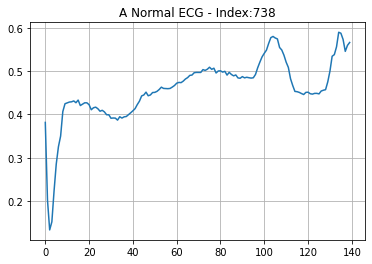

In [6]:
plt.grid()
selected_index = np.random.randint(normal_train_data.shape[0])
plt.plot(np.arange(140), normal_train_data[selected_index])
plt.title(f"A Normal ECG - Index:{selected_index}")
plt.show()

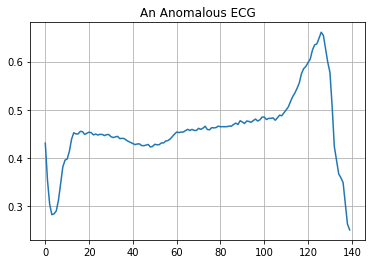

In [7]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

In [11]:
from tensorflow.keras import Model
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
          layers.Dense(32, activation="relu"),
          layers.Dense(16, activation="relu"),
          layers.Dense(8, activation="relu")])

        self.decoder = tf.keras.Sequential([
          layers.Dense(16, activation="relu"),
          layers.Dense(32, activation="relu"),
          layers.Dense(140, activation="sigmoid")])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AnomalyDetector()

In [12]:
autoencoder.compile(optimizer='adam', loss='mae')

In [13]:
history = autoencoder.fit(normal_train_data,
                          normal_train_data,
                          epochs=20,
                          batch_size=512,
                          validation_data=(test_data, test_data),
                          shuffle=True)

Epoch 1/20
5/5 [==============================] - 1s 46ms/step - loss: 0.0582 - val_loss: 0.0531
Epoch 2/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0554 - val_loss: 0.0514
Epoch 3/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0526 - val_loss: 0.0496
Epoch 4/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0492 - val_loss: 0.0479
Epoch 5/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0453 - val_loss: 0.0456
Epoch 6/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0412 - val_loss: 0.0439
Epoch 7/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0373 - val_loss: 0.0425
Epoch 8/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0340 - val_loss: 0.0405
Epoch 9/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0312 - val_loss: 0.0393
Epoch 10/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0292 - val_loss: 0.0383
Epoch 11/20
5/5 [====================

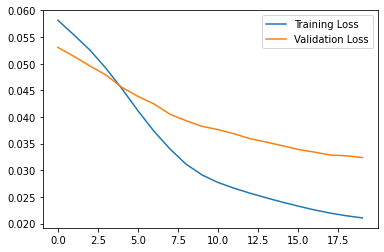

In [14]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

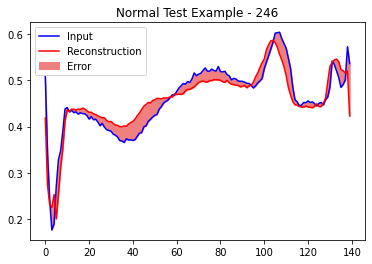

In [15]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

selected_index = np.random.randint(normal_test_data.shape[0])

plt.plot(normal_test_data[selected_index], 'b')
plt.plot(decoded_data[selected_index], 'r')
plt.title(f'Normal Test Example - {selected_index}')
plt.fill_between(np.arange(140), decoded_data[selected_index], normal_test_data[selected_index], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

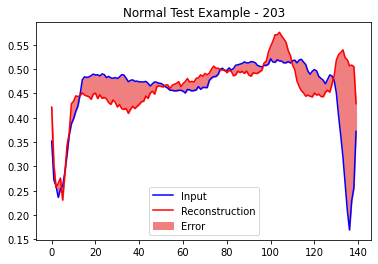

In [16]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

selected_index = np.random.randint(anomalous_test_data.shape[0])

plt.plot(anomalous_test_data[selected_index], 'b')
plt.plot(decoded_data[selected_index], 'r')
plt.title(f'Normal Test Example - {selected_index}')
plt.fill_between(np.arange(140), decoded_data[selected_index], anomalous_test_data[selected_index], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

74/74 [==============================] - 0s 815us/step


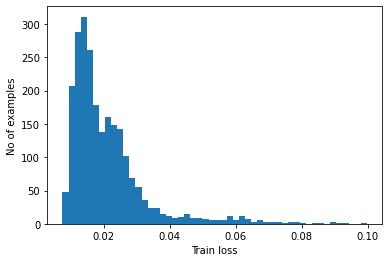

In [17]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [18]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.032589458


14/14 [==============================] - 0s 3ms/step


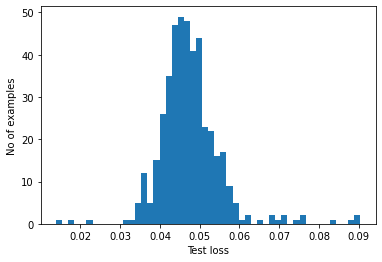

In [19]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [20]:
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Precision = {}".format(precision_score(labels, predictions)))
    print("Recall = {}".format(recall_score(labels, predictions)))
    
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.944
Precision = 0.9921875
Recall = 0.9071428571428571
